<a href="https://colab.research.google.com/github/heitorabqg/datascientist/blob/master/PSI5892_MLP4_luas_EC_1114.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# MLP genérica para solução do problemas das meias luas - Função custo da entropia cruzada

Neste exercício, vamos treinar uma rede MLP semelhante à do exercício anterior, mas usando a função custo da entropia cruzada.

In [78]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas. Note que, no caso da função custo da entropia cruzada, precisamos definir o sinal desejado no conjunto $\{0, 1\}$.

In [79]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = np.zeros((NB, 1))
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

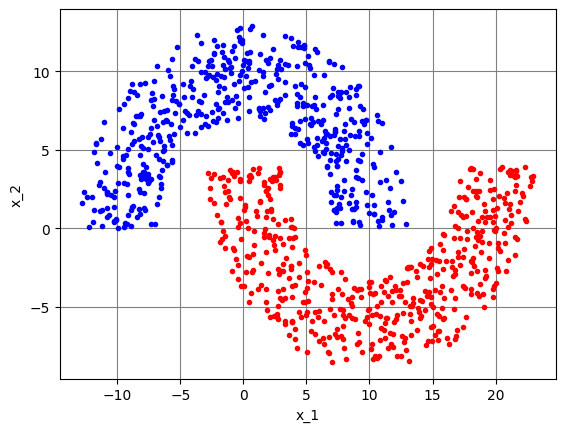

In [80]:
# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [81]:
# organizando os dados para entrada da MLP

# sinal de entrada
x = dados_treino[:, [0, 1]]

# sinal desejado
d = dados_treino[:, [2]]

# Exercício 1

Implemente uma função para treinamento de uma rede MLP genérica usando o algoritmo do gradiente estocástico, considerando a função custo da entropia cruzada, dada por

$$J_{\rm EC} = -\left[d_1(n){\rm ln}\left(y_1^{(L)}(n)\right) + \left(1 - d_1(n)\right){\rm ln}\left(1 - y_1^{(L)}(n)\right)\right].$$

Note que o caso com a entropia cruzada pressupõe que a rede possua apenas uma saída e, levando em conta que o sinal desejado tem elementos no conjunto $\{0, 1\}$, é necessário utilizar uma função de ativação sigmoidal.

Considere a seguinte assinatura para a função:

```python
def redeMLP_SGD_EC(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """
```

Após implementação da função para treinamento, treine uma rede para solucionar o problemas das meias luas considerando os dados `x`e `d` criados anteriormente. Faça um gráfico da função custo ao longo das épocas de treinamento.

## Resolução

In [82]:
def redeMLP_SGD_EC(x, d, Nn, eta, Nt, Nb, Ne, W0=None):
    """
    Treinamento de MLP com SGD + Entropia Cruzada
    - Saída sigmoidal
    """

    # número de mini-batches por época
    Nmb = int(np.floor(Nt / Nb))
    # Número de camadas com neurônios ou camadas da rede sem contar a entrada
    L = len(Nn) - 1

    # Inicialização dos pesos
    if W0 is None:
        W = [np.random.uniform(-0.5, 0.5, (Nn[j], Nn[j-1] + 1)) for j in range(1, len(Nn))]
    else:
        W = [np.copy(W0[j]) for j in range(len(W0))]

    # Função de ativação tangente hiperbólica (f) e derivada (df)
    f = lambda x: np.tanh(x)
    df = lambda x: 1 - np.tanh(x)**2

    # saída sigmoidal
    sig = lambda x: 1 / (1 + np.exp(-x))

    # Vetor para armazenar a entropia cruzada
    J_EC = np.zeros(Ne)

    # Loop de treinamento
    for epoca in range(Ne):

        soma_erro = 0

        # embaralha dados
        index = np.random.permutation(Nt)
        x = x[index, :]
        d = d[index, :]

        # Loop de Mini-Batch
        for i in range(Nmb):
            # Seleciona o mini-batch
            x_batch = x[i:i+Nb, :]
            d_batch = d[i:i+Nb, :]

            # Inicializa os gradientes
            # cria uma matriz de zeros com o mesmo formato que Wj
            # com W sendo uma lista e Wj uma matriz de pesos entre duas camadas
            grad = [np.zeros_like(Wj) for Wj in W]

            for n in range(len(x_batch)):

                # Cálculo progressivo (Forward Pass)
                # Listas criadas com L+1 posições
                # y[0] é entrada e y[1]... y[L] são as saídas das camadas ocultas e da saída final
                y = [None] * (L + 1)
                # valores da função de ativação
                v = [None] * (L + 1)

                y[0] = x_batch[n, :].reshape(-1, 1)

                for j in range(1, L + 1):
                    # adiciona bias
                    x_j = np.vstack(([1], y[j-1]))
                    v[j] = np.dot(W[j-1], x_j)

                    if j < L:
                        y[j] = f(v[j])
                    else:
                        y[j] = sig(v[j])   # saída

                # Custo
                yL = y[L]
                dL = d_batch[n, :].reshape(-1,1)

                custo = -(dL*np.log(yL + 1e-12) + (1-dL)*np.log(1-yL + 1e-12))
                soma_erro += custo

                # Cálculo regressivo (Backpropagation)
                delta = [None] * (L + 1)

                # camada de saída (sigmoide + entropia cruzada)
                delta[L] = (yL - dL)

                # outras camadas, percorrendo de trás para frente
                for j in range(L-1, 0, -1):
                    # W sem bias
                    W_no_bias = W[j][:, 1:]
                    delta[j] = df(v[j]) * np.dot(W_no_bias.T, delta[j+1])

                # acumula gradientes
                for j in range(1, L + 1):
                    # inclui bias
                    x_j = np.vstack(([1], y[j-1]))
                    grad[j-1] += eta * np.dot(delta[j], x_j.T)

            # atualização dos pesos
            for j in range(L):
                W[j] -= grad[j] / Nb

        # custo médio da época
        J_EC[epoca] = soma_erro.sum() / Nt

        # print(f"Época {epoca+1}/{Ne} – J_EC = {J_EC[epoca]:.5f}")

    # plot da função custo
    plt.figure(figsize=(7,5))
    plt.plot(10*np.log10(J_EC), 'b-', linewidth=2)
    plt.title('Função Custo – Entropia Cruzada')
    plt.xlabel('Épocas')
    plt.ylabel('J_EC')
    plt.grid(True)
    plt.show()

    return J_EC, W


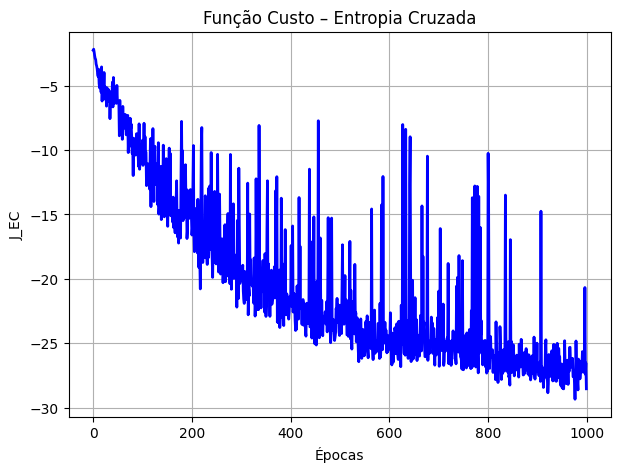

In [83]:
# treine uma rede para solucionar o problemas das meias luas considerando os dados xe d criados anteriormente.
# Faça um gráfico da função custo ao longo das épocas de treinamento.

Nn = [2, 3, 2, 1]

eta = 0.01
Nb  = 20
Ne  = 1000

W0 = None

# Treinamento da rede MLP com Entropia Cruzada
J_EC, W_final = redeMLP_SGD_EC(x, d, Nn, eta, Nt, Nb, Ne, W0)

# Exercício 2

Utilizando os seguintes dados de teste:

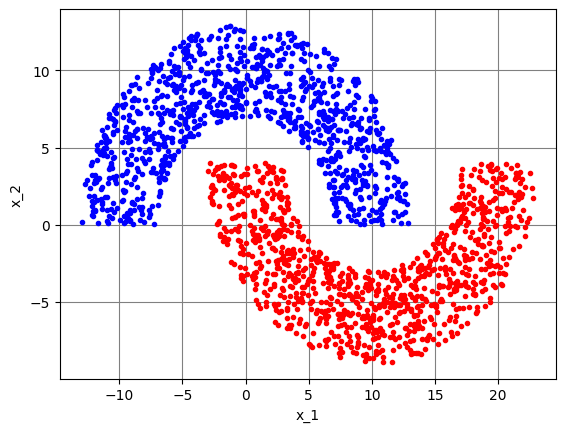

In [84]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

# entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada

# sinal desejado
dteste = dados_teste[:, 2].reshape(-1, 1)

Implemente uma função para teste da rede MLP treinada anteriormente, com a seguinte assinatura:

``` python
def redeMLP_SGD_EC_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """
```

Em seguida, faça o teste da rede com os dados de teste, apresente a taxa de erro e a curva de separação das duas regiões obtidas com a rede treinada.

## Resolução

In [85]:
def redeMLP_SGD_EC_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """

    L = len(Nn) - 1
    sig = lambda x: 1 / (1 + np.exp(-x))
    # função de ativação
    f = lambda x: np.tanh(x)

    y = np.zeros((Nteste, Nn[-1]))

    soma_erro = 0

    for n in range(Nteste):


        yj = x[n, :].reshape(-1, 1)

        for j in range(1, L + 1):

            xj = np.vstack(([1], yj))
            vj = np.dot(W[j-1], xj)

            if j < L:
                yj = f(vj)
            else:

                yj = sig(vj)

        y[n, :] = yj.T


        dj = d[n, :].reshape(-1, 1)
        y_s = yj


        eps = 1e-12
        J = -(dj*np.log(y_s + eps) + (1-dj)*np.log(1-y_s + eps))
        soma_erro += J

    J_EC = soma_erro.sum() / Nteste

    return J_EC, y


In [86]:
# Apresente a taxa de erro

# Teste da rede
J_teste, y_teste = redeMLP_SGD_EC_teste(xteste, dteste, W_final, Nn, Nteste)


# Classificação teste
yclass = (y_teste >= 0.5).astype(int)

# Taxa de erro
erros = np.sum(yclass != dteste)
taxa_erro = erros / Nteste * 100
print(f"Taxa de erro no teste = {taxa_erro:.2f}%")



Taxa de erro no teste = 0.10%


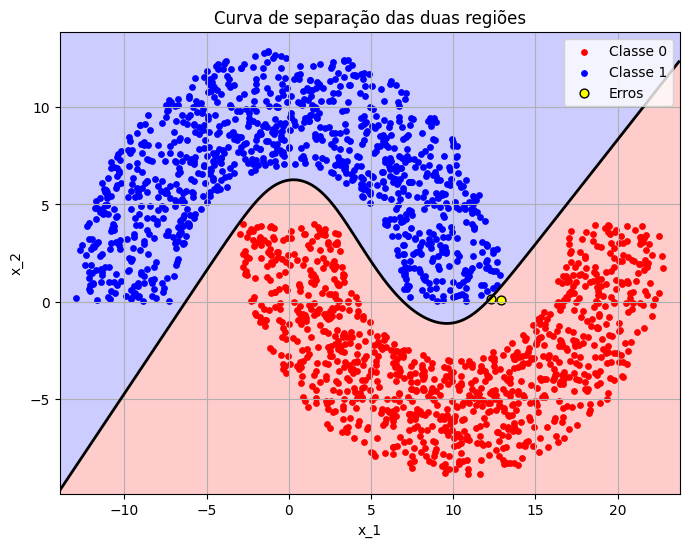

In [87]:
# Curva de Separação

# Geração de uma grade de pontos
x1_min, x1_max = xteste[:,0].min()-1, xteste[:,0].max()+1
x2_min, x2_max = xteste[:,1].min()-1, xteste[:,1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                       np.linspace(x2_min, x2_max, 200))
X_grid = np.c_[xx1.ravel(), xx2.ravel()]

# Saída da rede na grade, não nos interessa J_EC, por isso ignoramos sua saída com _,
_, y_grid = redeMLP_SGD_EC_teste(X_grid, np.zeros((len(X_grid),1)), W_final, Nn, len(X_grid))
Z = y_grid.reshape(xx1.shape)


plt.figure(figsize=(8,6))

plt.contourf(xx1, xx2, Z, levels=[0, 0.5, 1], colors=['red', 'blue'], alpha=0.2)

# Linha de separação em 0.5
cs = plt.contour(xx1, xx2, Z, levels=[0.5], colors='k', linewidths=2)


# Dados reais de teste
plt.scatter(xteste[dteste[:,0]==0,0], xteste[dteste[:,0]==0,1], c='red', label='Classe 0', s=15)
plt.scatter(xteste[dteste[:,0]==1,0], xteste[dteste[:,0]==1,1], c='blue', label='Classe 1', s=15)

# Pontos com classificação errada
plt.scatter(xteste[yclass[:,0]!=dteste[:,0],0],
            xteste[yclass[:,0]!=dteste[:,0],1],
            c='yellow', s=40, edgecolors='k', label='Erros')

plt.title("Curva de separação das duas regiões")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
plt.grid(True)
plt.show()